In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import sys
from pathlib import Path
import os
import math
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
#Data constants

shapes_B = [2, 4]#[2, 2]
scales_B = [3, 3]
k_B = len(scales_B) # Number of classes
d_B = 2 # Number of dimensions
p_c_B = [1/len(shapes_B)]*len(shapes_B) # Uniform distributon over classes
tag_B = f'k_{k_B}_d{d_B}_shapes{shapes_B}_scales{scales_B}_pc{p_c_B}'.replace(" ", "")

shapes_A = [2, 6]#[2, 2]
scales_A = [5, 3]
k_A = len(scales_A) # Number of classes
d_A = 2 # Number of dimensions
p_c_A = [1/len(shapes_A)]*len(shapes_A) # Uniform distributon over classes
tag_A = f'k_{k_A}_d{d_A}_shapes{shapes_A}_scales{scales_A}_pc{p_c_A}'.replace(" ", "")

In [5]:
def load_df(folder_path, n_runs):
    filenames = [f"{folder_path}/results_run{i}.csv" for i in range(n_runs)]
    df = pd.concat((pd.read_csv(f) for f in filenames), ignore_index=True)
    return df

model_names = [#"NNE", 
               #"CL",
               "EDL"]
               #"MCD", 
               #"BNN"]

folder_names = ["evidential"]
folder_paths_A = [f"DNN/gridsearch/train_n_50000_{tag_A}/{folder}" for folder in folder_names]

n_runs = 5

dfs_A = [load_df(path, n_runs) for path in folder_paths_A]

In [48]:
hyperparams = {
        "lr" : [0.1, 0.01, 0.001],
        "weight_decay" : [0.1, 0.01, 0.001],
        "layers" : [1, 3, 8]
    }
metric_keys = ["ACC", "LogLoss", "Mean KL-div", "ECE", "WD", "Mean UQ", 
                       "Std UQ", "Min UQ", "Max UQ",
                       "Mean Pc1 OOD", "Std Pc1 OOD", "Max Pc1 OOD", "Min Pc1 OOD",
                       "Mean UQ OOD", "Std UQ OOD", "Max UQ OOD", "Min UQ OOD"]
EDL_acoef = [0.05, 0.1, 0.2] #annealing_coef

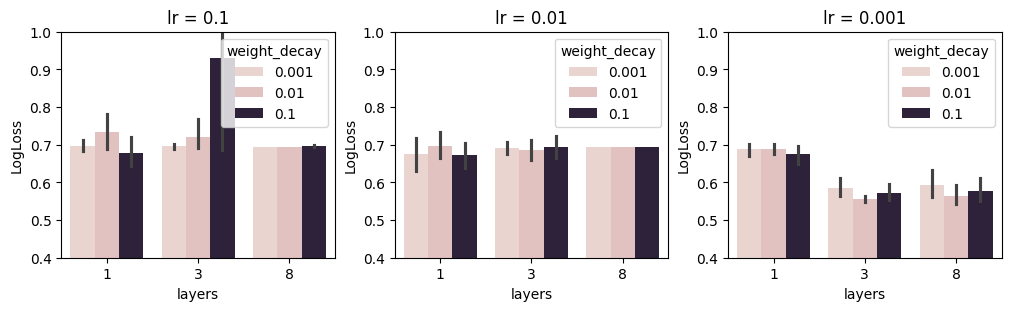

In [40]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 3),  layout="constrained")
i = 0
for value in hyperparams["lr"]:
    df_subset = dfs_A[0][dfs_A[0]["lr"] == value]
    sn.barplot(df_subset, x="layers", y="LogLoss", hue="weight_decay", ax=axs[i])
    axs[i].set_title(f"lr = {value}")
    axs[i].set_ylim(0.4, 1)
    i = i + 1

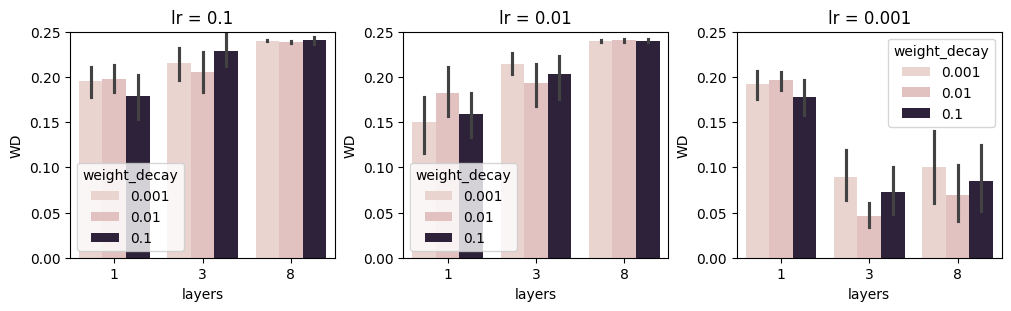

In [89]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 3),  layout="constrained")
i = 0
for value in hyperparams["lr"]:
    df_subset = dfs_A[0][dfs_A[0]["lr"] == value]
    sn.barplot(df_subset, x="layers", y="WD", hue="weight_decay", ax=axs[i])
    axs[i].set_title(f"lr = {value}")
    axs[i].set_ylim(0, 0.25)
    i = i + 1

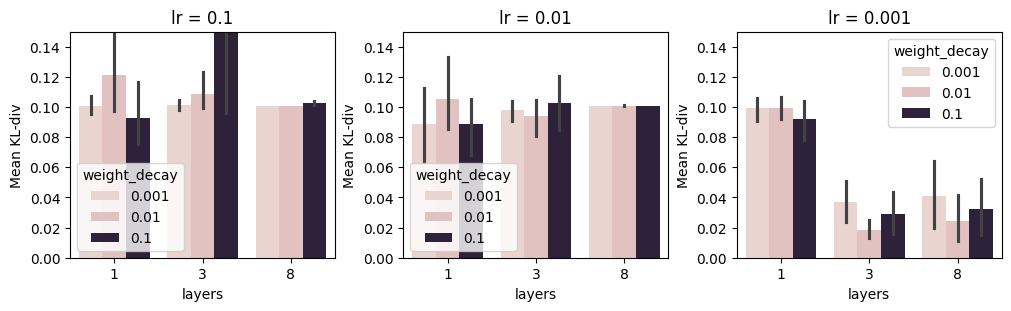

In [90]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 3),  layout="constrained")
i = 0
for value in hyperparams["lr"]:
    df_subset = dfs_A[0][dfs_A[0]["lr"] == value]
    sn.barplot(df_subset, x="layers", y="Mean KL-div", hue="weight_decay", ax=axs[i])
    axs[i].set_title(f"lr = {value}")
    axs[i].set_ylim(0, 0.15)
    i = i + 1

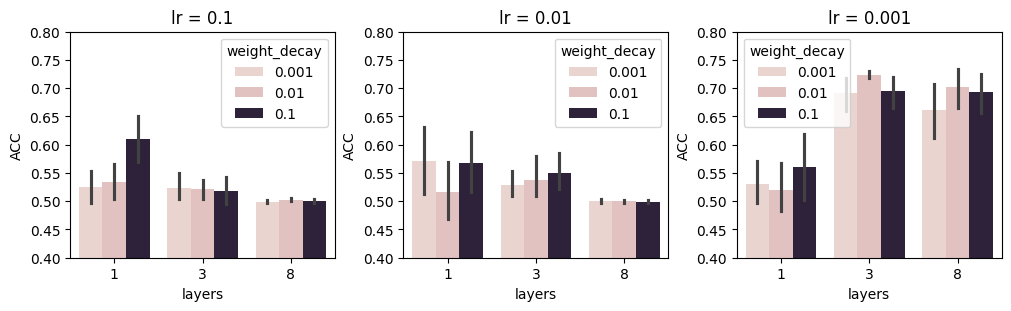

In [39]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 3),  layout="constrained")
i = 0
for value in hyperparams["lr"]:
    df_subset = dfs_A[0][dfs_A[0]["lr"] == value]
    sn.barplot(df_subset, x="layers", y="ACC", hue="weight_decay", ax=axs[i])
    axs[i].set_title(f"lr = {value}")
    axs[i].set_ylim(0.4, 0.8)
    i = i + 1

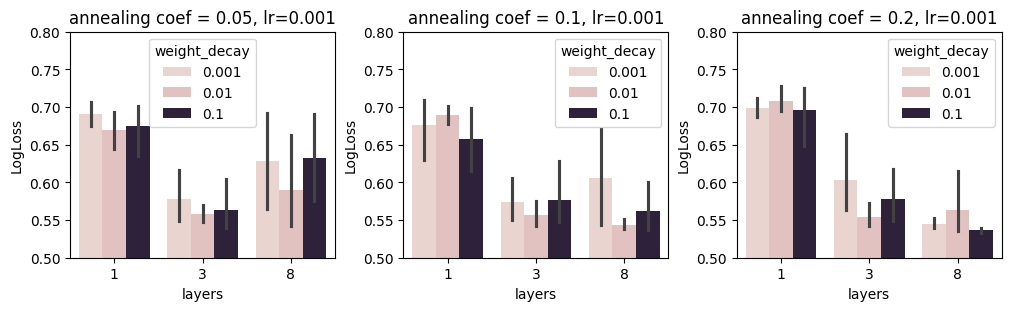

In [78]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 3),  layout="constrained")
i = 0
for value in EDL_acoef:
    df_subset = dfs_A[0][dfs_A[0]["annealing_coef"] == value]
    df_subset = df_subset[df_subset["lr"] == 0.001]
    sn.barplot(df_subset, x="layers", y="LogLoss", hue="weight_decay", ax=axs[i])
    axs[i].set_title(f"annealing coef = {value}, lr=0.001")
    axs[i].set_ylim(0.5, 0.8)
    i = i + 1

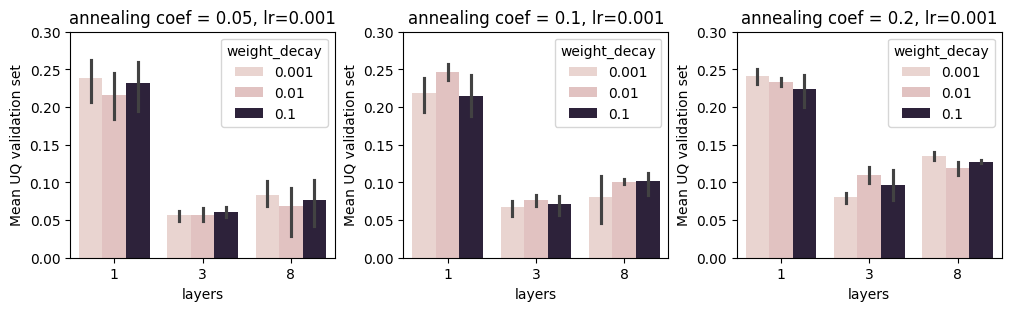

In [79]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 3),  layout="constrained")
i = 0
for value in EDL_acoef:
    df_subset = dfs_A[0][dfs_A[0]["annealing_coef"] == value]
    df_subset = df_subset[df_subset["lr"] == 0.001]
    sn.barplot(df_subset, x="layers", y="Mean UQ", hue="weight_decay", ax=axs[i])
    axs[i].set_title(f"annealing coef = {value}, lr=0.001")
    axs[i].set_ylim(0, 0.3)
    axs[i].set_ylabel("Mean UQ validation set")
    i = i + 1

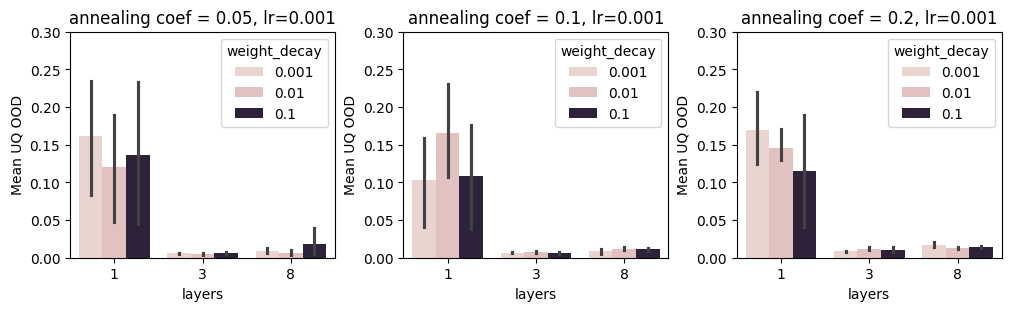

In [80]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 3),  layout="constrained")
i = 0
for value in EDL_acoef:
    df_subset = dfs_A[0][dfs_A[0]["annealing_coef"] == value]
    df_subset = df_subset[df_subset["lr"] == 0.001]
    sn.barplot(df_subset, x="layers", y="Mean UQ OOD", hue="weight_decay", ax=axs[i])
    axs[i].set_title(f"annealing coef = {value}, lr=0.001")
    axs[i].set_ylim(0, 0.3)
    axs[i].set_ylabel("Mean UQ OOD")
    i = i + 1

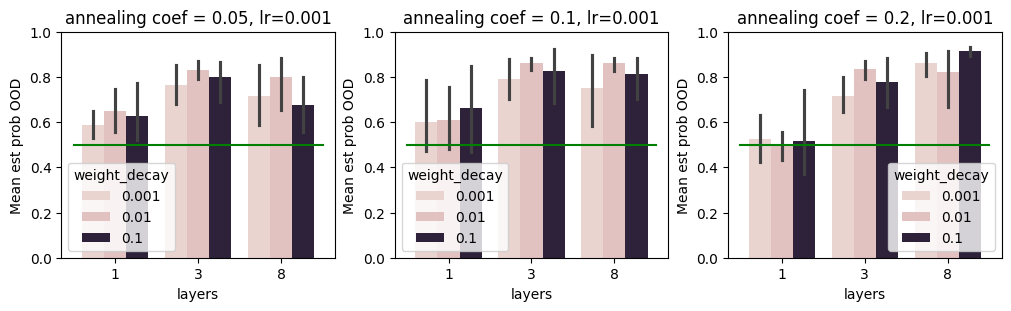

In [81]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 3),  layout="constrained")
i = 0
for value in EDL_acoef:
    df_subset = dfs_A[0][dfs_A[0]["annealing_coef"] == value]
    df_subset = df_subset[df_subset["lr"] == 0.001]
    sn.barplot(df_subset, x="layers", y="Mean Pc1 OOD", hue="weight_decay", ax=axs[i])
    axs[i].set_title(f"annealing coef = {value}, lr=0.001")
    axs[i].set_ylim(0, 1)
    x = [-0.5, 1, 2.5]
    y = [0.5, 0.5, 0.5]
    axs[i].plot(x, y, c="green", label=f"p=0.5")
    axs[i].set_ylabel("Mean est prob OOD")
    i = i + 1

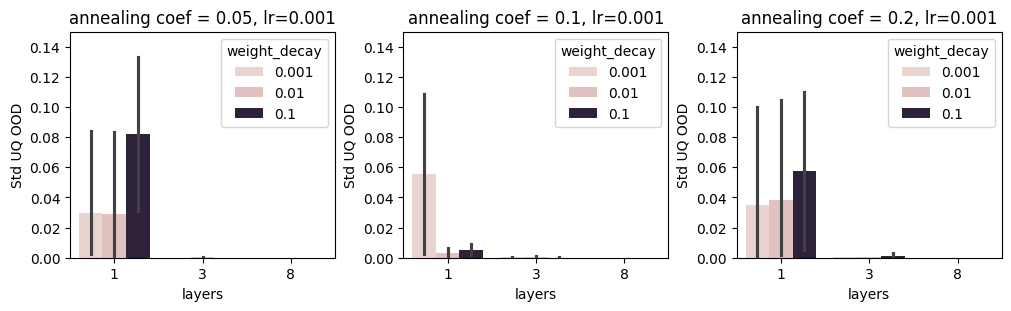

In [82]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 3),  layout="constrained")
i = 0
for value in EDL_acoef:
    df_subset = dfs_A[0][dfs_A[0]["annealing_coef"] == value]
    df_subset = df_subset[df_subset["lr"] == 0.01]
    sn.barplot(df_subset, x="layers", y="Std UQ OOD", hue="weight_decay", ax=axs[i])
    axs[i].set_title(f"annealing coef = {value}, lr=0.001")
    axs[i].set_ylim(0, 0.15)
    axs[i].set_ylabel("Std UQ OOD")
    i = i + 1

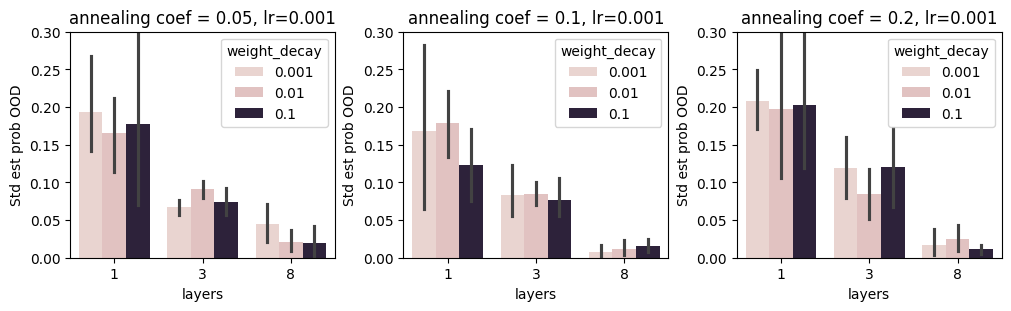

In [84]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 3),  layout="constrained")
i = 0
for value in EDL_acoef:
    df_subset = dfs_A[0][dfs_A[0]["annealing_coef"] == value]
    df_subset = df_subset[df_subset["lr"] == 0.001]
    sn.barplot(df_subset, x="layers", y="Std Pc1 OOD", hue="weight_decay", ax=axs[i])
    axs[i].set_title(f"annealing coef = {value}, lr=0.001")
    axs[i].set_ylim(0, 0.3)
    axs[i].set_ylabel("Std est prob OOD")
    i = i + 1